**BacktestEngine notebook**

The purpose of this notebook is to illustrate how to use the `BacktestEngine` class to do the back-testing. To have the greatest flexibility, this engine is designed to work for any model objects which have a `fit` method and a `predict` method, by writing some call back functions. The default settings work for **Orbit** model object automatically. Currently, there are two schemes supported for the back-testing engine: expanding window and rolling window.

* expanding window: for each back-testing model training, the train start date is fixed, while the train end date is extended forward.
* rolling window: for each back-testing model training, the training window length is fixed but the window is moving forward.

In [1]:
import pandas as pd
import numpy as np

# from uTS.lgt import LGT
# from uTS.utils.utils import plot_predicted_data

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

import sys
sys.path.append("../../uTS")
from uTS.lgt import LGT
from uTS.backtest import BacktestEngine, mape, smape, wmape

## Load data

In [2]:
data_path = "../examples/data/iclaims.example.csv"
raw_data = pd.read_csv(data_path, parse_dates=['week'])

## log transformation
data = raw_data.copy()
data[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] = \
    data[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log, axis=1)

print(data.shape)
data.head(5)

(443, 5)


,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


## Orbit model object

###  expanding window

In [3]:
date_col = 'week'
response_col = 'claims'
regressor_col = ['trend.unemploy', 'trend.filling', 'trend.job']

min_train_len = 300
forecast_len = 20
incremental_len = 20

mod = LGT(date_col = date_col,
    response_col = response_col,
    regressor_col = regressor_col,
    seasonality = 52,
    seed = 8888,
    predict_method = 'map'
)

#### initialization and create meta data

In [4]:
bt_expand = BacktestEngine(mod, data)

In [5]:
bt_expand.create_meta(min_train_len, incremental_len, forecast_len, 
                           start_date=None, end_date=None, keep_cols=None,
                           scheme='expanding')

In [6]:
bt_expand.bt_meta

{0: {'model': <uTS.lgt.LGT at 0x10b66cc18>,
  'train_start_date': Timestamp('2010-01-03 00:00:00'),
  'train_end_date': Timestamp('2015-09-27 00:00:00'),
  'train_idx': range(0, 300),
  'test_idx': range(300, 320),
  'forecast_dates': 300   2015-10-04
  301   2015-10-11
  302   2015-10-18
  303   2015-10-25
  304   2015-11-01
  305   2015-11-08
  306   2015-11-15
  307   2015-11-22
  308   2015-11-29
  309   2015-12-06
  310   2015-12-13
  311   2015-12-20
  312   2015-12-27
  313   2016-01-03
  314   2016-01-10
  315   2016-01-17
  316   2016-01-24
  317   2016-01-31
  318   2016-02-07
  319   2016-02-14
  Name: week, dtype: datetime64[ns]},
 1: {'model': <uTS.lgt.LGT at 0x11c6656d8>,
  'train_start_date': Timestamp('2010-01-03 00:00:00'),
  'train_end_date': Timestamp('2016-02-14 00:00:00'),
  'train_idx': range(0, 320),
  'test_idx': range(320, 340),
  'forecast_dates': 320   2016-02-21
  321   2016-02-28
  322   2016-03-06
  323   2016-03-13
  324   2016-03-20
  325   2016-03-27
  

#### run back-testing

In [7]:
bt_expand.run(verbose=True, save_results=False, pred_col='prediction')

  0%|          | 0/7 [00:00<?, ?it/s]

run expanding window back-testing:
training and forcasting for horizon 10/04/2015 -- 02/14/2016


 29%|██▊       | 2/7 [00:00<00:01,  4.96it/s]

training and forcasting for horizon 02/21/2016 -- 07/03/2016
training and forcasting for horizon 07/10/2016 -- 11/20/2016


 57%|█████▋    | 4/7 [00:00<00:00,  5.21it/s]

training and forcasting for horizon 11/27/2016 -- 04/09/2017
training and forcasting for horizon 04/16/2017 -- 08/27/2017


 71%|███████▏  | 5/7 [00:00<00:00,  4.97it/s]

training and forcasting for horizon 09/03/2017 -- 01/14/2018


 86%|████████▌ | 6/7 [00:01<00:00,  4.91it/s]

training and forcasting for horizon 01/21/2018 -- 06/03/2018


100%|██████████| 7/7 [00:01<00:00,  4.88it/s]


In [8]:
bt_expand.bt_res.head()

,train_start_date,train_end_date,forecast_dates,actual,pred,pred_horizon
0,2010-01-03,2015-09-27,2015-10-04,12.333480,12.416718,1
1,2010-01-03,2015-09-27,2015-10-11,12.454970,12.489585,2
2,2010-01-03,2015-09-27,2015-10-18,12.358193,12.414058,3
3,2010-01-03,2015-09-27,2015-10-25,12.410502,12.457153,4
4,2010-01-03,2015-09-27,2015-11-01,12.462419,12.455492,5


#### back-testing result analysis

Internal method is provided to give a quick analysis of the back-testing runs. It is flexible for uses to define their own metrics and aggregation strategy based on the back-testing run results.

In [9]:
bt_expand.analyze(metrics='wmape', transform=np.exp)
bt_expand.analyze_res

{'metric_name': 'wmape', 'metric_per_btmod': train_end_date
 2015-09-27    0.057101
 2016-02-14    0.058509
 2016-07-03    0.040739
 2016-11-20    0.061060
 2017-04-09    0.040686
 2017-08-27    0.052206
 2018-01-14    0.038269
 dtype: float64, 'metric_geo': 0.050695471515561, 'metric_per_horizon': pred_horizon
 1     0.061808
 2     0.053095
 3     0.045684
 4     0.051220
 5     0.036045
 6     0.043815
 7     0.045534
 8     0.024451
 9     0.050736
 10    0.045465
 11    0.036228
 12    0.048353
 13    0.065347
 14    0.057314
 15    0.079648
 16    0.059181
 17    0.059589
 18    0.064969
 19    0.041354
 20    0.039959
 dtype: float64}

#### plotting

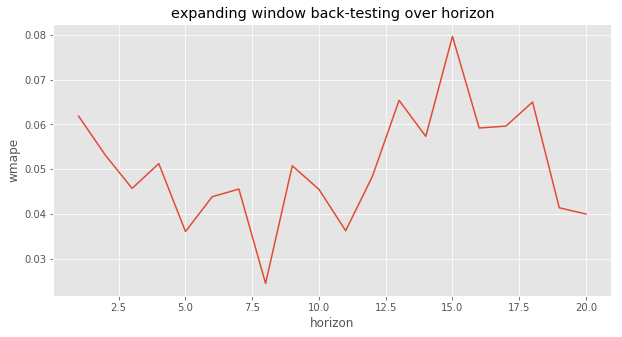

In [10]:
fig = bt_expand.plot_horizon(figsize=(10, 5))

### rolling window

In [11]:
min_train_len = 300
forecast_len = 20
incremental_len = 20

mod = LGT(date_col = date_col,
    response_col = response_col,
    regressor_col = regressor_col,
    seasonality = 52,
    seed = 8888,
    predict_method = 'map'
)

In [12]:
bt_roll = BacktestEngine(mod, data)
bt_roll.create_meta(min_train_len, incremental_len, forecast_len, 
                           start_date=None, end_date=None, keep_cols=None,
                           scheme='rolling')
bt_roll.run(verbose=True, save_results=False, pred_col='prediction')
bt_roll.bt_res.head()

  0%|          | 0/7 [00:00<?, ?it/s]

run rolling window back-testing:
training and forcasting for horizon 10/04/2015 -- 02/14/2016


 14%|█▍        | 1/7 [00:00<00:01,  4.92it/s]

training and forcasting for horizon 02/21/2016 -- 07/03/2016


 43%|████▎     | 3/7 [00:00<00:00,  5.11it/s]

training and forcasting for horizon 07/10/2016 -- 11/20/2016
training and forcasting for horizon 11/27/2016 -- 04/09/2017


 57%|█████▋    | 4/7 [00:00<00:00,  5.13it/s]

training and forcasting for horizon 04/16/2017 -- 08/27/2017


 86%|████████▌ | 6/7 [00:01<00:00,  5.28it/s]

training and forcasting for horizon 09/03/2017 -- 01/14/2018
training and forcasting for horizon 01/21/2018 -- 06/03/2018


100%|██████████| 7/7 [00:01<00:00,  5.45it/s]


,train_start_date,train_end_date,forecast_dates,actual,pred,pred_horizon
0,2010-01-03,2015-09-27,2015-10-04,12.333480,12.416718,1
1,2010-01-03,2015-09-27,2015-10-11,12.454970,12.489585,2
2,2010-01-03,2015-09-27,2015-10-18,12.358193,12.414058,3
3,2010-01-03,2015-09-27,2015-10-25,12.410502,12.457153,4
4,2010-01-03,2015-09-27,2015-11-01,12.462419,12.455492,5


## Sklearn model object - Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor

def fit_callbacks_sklearn(model, train_df, response_col, regressor_col):
    y = train_df[response_col]
    X = train_df[regressor_col]
    model.fit(X, y)
    return 

def pred_callbacks_sklearn(model, test_df, response_col, regressor_col):
    return model.predict(test_df[regressor_col])

In [14]:
date_col = 'week'
response_col = 'claims'
regressor_col = ['trend.unemploy', 'trend.filling', 'trend.job']

min_train_len = 300
forecast_len = 20
incremental_len = 20

mod = RandomForestRegressor(n_estimators = 50)

In [15]:
bt_expand = BacktestEngine(mod, data, date_col=date_col, response_col=response_col)

bt_expand.create_meta(min_train_len, incremental_len, forecast_len, 
                           start_date=None, end_date=None, keep_cols=None,
                           scheme='expanding')

bt_expand.run(verbose=True, save_results=False, pred_col=None,
              fit_callbacks=fit_callbacks_sklearn, pred_callbacks=pred_callbacks_sklearn,
              response_col=response_col, regressor_col=regressor_col)

bt_expand.bt_res.head()

 29%|██▊       | 2/7 [00:00<00:00, 14.92it/s]

run expanding window back-testing:
training and forcasting for horizon 10/04/2015 -- 02/14/2016
training and forcasting for horizon 02/21/2016 -- 07/03/2016
training and forcasting for horizon 07/10/2016 -- 11/20/2016
training and forcasting for horizon 11/27/2016 -- 04/09/2017


100%|██████████| 7/7 [00:00<00:00, 15.60it/s]

training and forcasting for horizon 04/16/2017 -- 08/27/2017
training and forcasting for horizon 09/03/2017 -- 01/14/2018
training and forcasting for horizon 01/21/2018 -- 06/03/2018


,train_start_date,train_end_date,forecast_dates,actual,pred,pred_horizon
0,2010-01-03,2015-09-27,2015-10-04,12.333480,12.269815,1
1,2010-01-03,2015-09-27,2015-10-11,12.454970,12.314558,2
2,2010-01-03,2015-09-27,2015-10-18,12.358193,12.298409,3
3,2010-01-03,2015-09-27,2015-10-25,12.410502,12.297171,4
4,2010-01-03,2015-09-27,2015-11-01,12.462419,12.288372,5


## Prophet model object

In [16]:
from fbprophet import Prophet
import inspect

def model_callbacks_prophet(model):
    def _get_params(instance):
        """get initilization parameters via a prophet model object"""
        class_hierarchy = inspect.getmro(Prophet)
        init_signatures = [inspect.signature(c.__init__) for c in class_hierarchy if type(c) is not object]

        all_params = []
        for sig in init_signatures:
            params = [p for p in sig.parameters.values()
                      if p.name != 'self' and p.kind != p.VAR_KEYWORD
                      and p.kind != p.VAR_POSITIONAL]
            all_params.extend(params)
        param_names = [p.name for p in all_params]
        out = dict()
        for key in param_names:
            out[key] = getattr(instance, key)

        return out

    def bind(instance, _get_params):
        def binding_scope_fn(): 
            return _get_params(instance)
        return binding_scope_fn
    model.get_params = bind(model, _get_params)
    
    return model


def fit_callbacks_prophet(model, train_df, date_col, response_col, regressor_col):
    train_df = train_df.rename(columns={date_col: "ds", response_col: "y"})
    for regressor in regressor_col:
        model.add_regressor(regressor) 
    model.fit(train_df)
    
    return 

def pred_callbacks_prophet(model, test_df, date_col, response_col, regressor_col):
    test_df = test_df.rename(columns={date_col: "ds", response_col: "y"})
    
    return model.predict(test_df)

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [17]:
date_col = 'week'
response_col = 'claims'
regressor_col = ['trend.unemploy', 'trend.filling', 'trend.job']

min_train_len = 300
forecast_len = 20
incremental_len = 20

mod = Prophet()

In [18]:
bt_expand = BacktestEngine(mod, data, date_col=date_col, response_col=response_col, 
                           model_callbacks=model_callbacks_prophet)

bt_expand.create_meta(min_train_len, incremental_len, forecast_len, 
                           start_date=None, end_date=None, keep_cols=None,
                           scheme='expanding')

bt_expand.run(verbose=True, save_results=False, 
              fit_callbacks=fit_callbacks_prophet, pred_callbacks=pred_callbacks_prophet, pred_col='yhat', 
              date_col=date_col, response_col=response_col, regressor_col=regressor_col)

bt_expand.bt_res.head()

  0%|          | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


run expanding window back-testing:
training and forcasting for horizon 10/04/2015 -- 02/14/2016


 14%|█▍        | 1/7 [00:01<00:11,  1.96s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training and forcasting for horizon 02/21/2016 -- 07/03/2016


 29%|██▊       | 2/7 [00:03<00:09,  1.96s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training and forcasting for horizon 07/10/2016 -- 11/20/2016


 43%|████▎     | 3/7 [00:05<00:07,  1.95s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training and forcasting for horizon 11/27/2016 -- 04/09/2017


 57%|█████▋    | 4/7 [00:07<00:05,  1.96s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training and forcasting for horizon 04/16/2017 -- 08/27/2017


 71%|███████▏  | 5/7 [00:09<00:03,  1.96s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training and forcasting for horizon 09/03/2017 -- 01/14/2018


 86%|████████▌ | 6/7 [00:11<00:02,  2.02s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training and forcasting for horizon 01/21/2018 -- 06/03/2018


100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


,train_start_date,train_end_date,forecast_dates,actual,pred,pred_horizon
0,2010-01-03,2015-09-27,2015-10-04,12.333480,12.353443,1
1,2010-01-03,2015-09-27,2015-10-11,12.454970,12.408038,2
2,2010-01-03,2015-09-27,2015-10-18,12.358193,12.444854,3
3,2010-01-03,2015-09-27,2015-10-25,12.410502,12.447369,4
4,2010-01-03,2015-09-27,2015-11-01,12.462419,12.449554,5


In [20]:
bt_expand.analyze(metrics='wmape', transform=np.exp)
bt_expand.analyze_res

{'metric_name': 'wmape', 'metric_per_btmod': train_end_date
 2015-09-27    0.085644
 2016-02-14    0.054836
 2016-07-03    0.040277
 2016-11-20    0.055579
 2017-04-09    0.039051
 2017-08-27    0.081368
 2018-01-14    0.065742
 dtype: float64, 'metric_geo': 0.06167209738356981, 'metric_per_horizon': pred_horizon
 1     0.099511
 2     0.061888
 3     0.054195
 4     0.026944
 5     0.047390
 6     0.070695
 7     0.041036
 8     0.041242
 9     0.061111
 10    0.074043
 11    0.028595
 12    0.056108
 13    0.062844
 14    0.083796
 15    0.110110
 16    0.045784
 17    0.049211
 18    0.061294
 19    0.105506
 20    0.043038
 dtype: float64}